# Importación de _data_

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

In [113]:

first_row = ['ligero', 'moto', 'auto', 'station_wagon', 'pesado', 'camion']
second_row = ['bicicleta', 'moto_lineal', 'trimoto', 'moto_carga', 'particular', 'colectivo', 'taxi', 'particular', 'colectivo', 'taxi', 'miniban', 'microbus', 'camioneta', 'bus', '<12tn', '>12tn']
column_index = pd.MultiIndex.from_tuples([
    *zip( ((first_row[0] * 1, ) + (first_row[1], ) * 3 + (first_row[2], ) * 3 + (first_row[3], ) * 3 + (first_row[4], ) * 4 + (first_row[5], ) * 2), second_row )
])

In [114]:
DATA_PATH = './data/test.xlsx'
data = pd.read_excel(DATA_PATH)
data = data.dropna(how='any')
data = data.set_index('Hora')
# data.index.name = 'hora'
data.columns = column_index
hora = data.index.str.extract('^(\d?\d:\d\d)').astype('string').values
data.index = pd.Index(hora.ravel(), name='hora', dtype=str)
data.index = pd.to_datetime(data.index)
data.head()
# data.index.str.extract('^.*(\d?\d:\d\d)')

ligero        moto                          auto  \
                    bicicleta moto_lineal trimoto moto_carga particular   
hora                                                                      
2022-10-04 06:00:00         0           4       0          0         24   
2022-10-04 06:15:00         0           2       1          1         18   
2022-10-04 06:30:00         0           4       4          0         31   
2022-10-04 06:45:00         0           2       2          0         15   
2022-10-04 07:00:00         0           2       0          0         11   

                                   station_wagon                 pesado  \
                    colectivo taxi    particular colectivo taxi miniban   
hora                                                                      
2022-10-04 06:00:00         0    5             5         0    0       5   
2022-10-04 06:15:00         0    3             5         0    1       0   
2022-10-04 06:30:00         0    5             2         0    1       2   
2022-10-04 06:45:00         0    4             6         0    0       1   
2022-10-04 07:00:00         0    9             2         0    3       4   

                                           camion        
                    microbus camioneta bus  <12tn >12tn  
hora                                                     
2022-10-04 06:00:00        5         5   5     10     6  
2022-10-04 06:15:00        9         8   3      5     3  
2022-10-04 06:30:00        8         9   1      5     9  
2022-10-04 06:45:00        7         7   1      6     4  
2022-10-04 07:00:00       10         5   0      3     4

## Gráficas por tipo

In [115]:
period = '15T' # -> 15 minutos
data_resampled = data.resample(rule=period,label='left',closed='left').sum()

In [116]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette('bright', 4))

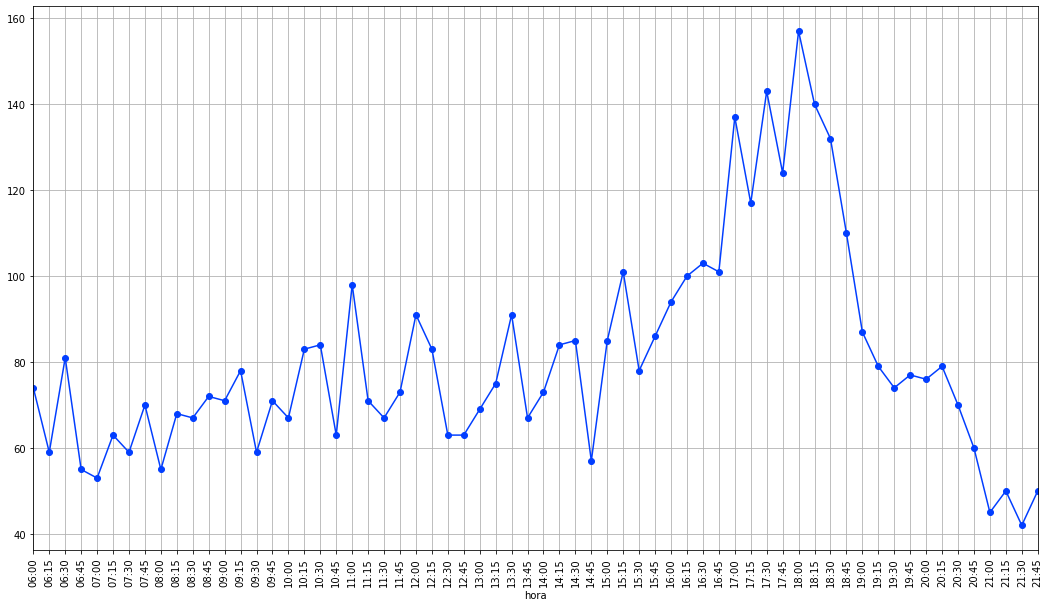

In [117]:
x_labels = data_resampled.index.astype('string').str.extract('(\d\d:\d\d):\d\d$').values.ravel().tolist()
x_ticks = pd.to_datetime(x_labels).tolist()

fig, axes = plt.subplots(figsize=(18,10))
data_resampled.sum(axis=1).plot(ax = axes, xticks=x_ticks,rot=90, grid=True, colormap=cmap, marker='o', xlim=(min(x_ticks), max(x_ticks)))
axes.set_xticklabels(x_labels)
plt.show()

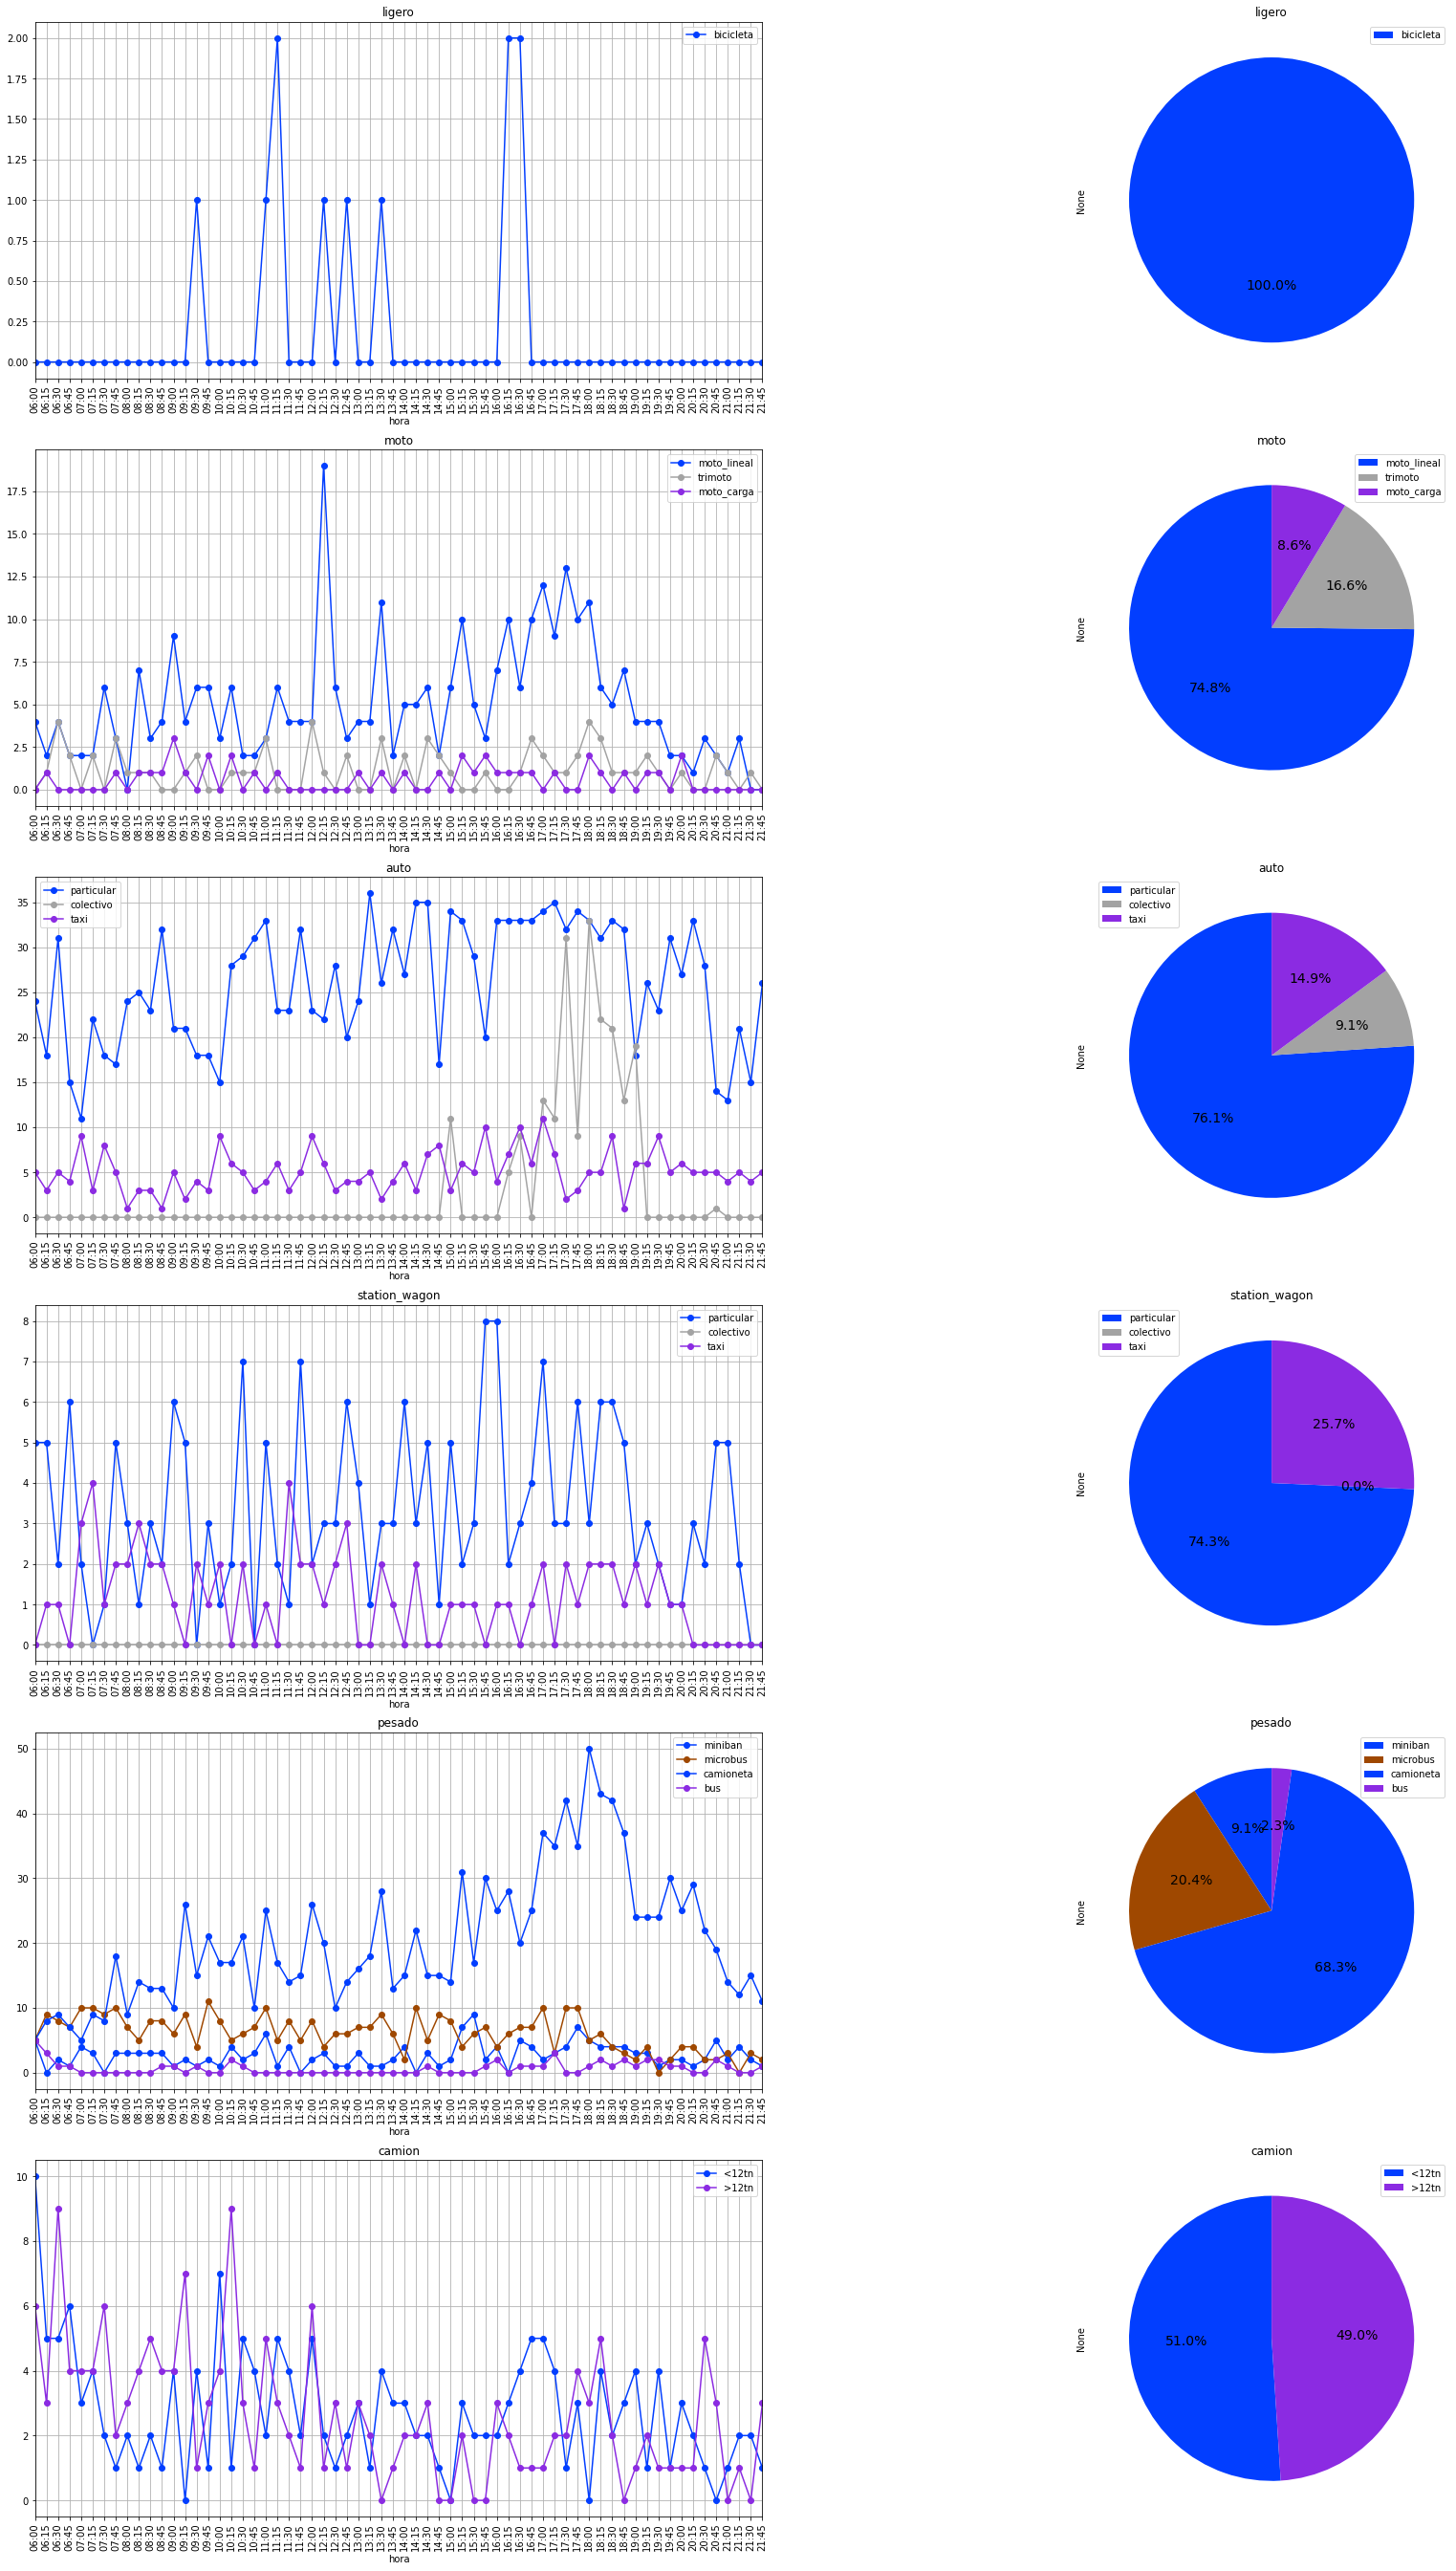

In [157]:
counter_idx = 0
g = []
pies = []
fig, axes = plt.subplots(len(first_row), 2, figsize=(30,48))
for ax, column_1 in zip(axes.reshape(-1,2), first_row):
    data_ = data_resampled[column_1]
    # ax[0].plot_date(data_.index.to_pydatetime(), y)
    # ax[0].set_xticks(x_ticks)
    # ax[0].set_xticklabels(x_labels)
    # ax[0].xaxis.grid(True, which="major")
    data_.plot(ax=ax[0], xticks=x_ticks,rot=90, grid=True, title=column_1, colormap=cmap, marker='o', xlim=(min(x_ticks), max(x_ticks)))
    ax[0].set_xticklabels(x_labels)
    ax[1].set_title(column_1)
    data_.sum(axis=0).plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, colormap=cmap, legend=True, labels=None, fontsize=14)
# plt.xticks(ticks = data_resampled.index,labels=[str(i) for i in data_resampled.index])
plt.show()

In [119]:
data_resampled.describe()

ligero        moto                             auto             \
       bicicleta moto_lineal    trimoto moto_carga particular  colectivo   
count  64.000000   64.000000  64.000000  64.000000  64.000000  64.000000   
mean    0.171875    5.015625   1.109375   0.578125  26.000000   3.093750   
std     0.489726    3.529882   1.156310   0.730399   6.794022   7.444437   
min     0.000000    0.000000   0.000000   0.000000  11.000000   0.000000   
25%     0.000000    2.750000   0.000000   0.000000  21.000000   0.000000   
50%     0.000000    4.000000   1.000000   0.000000  26.500000   0.000000   
75%     0.000000    6.000000   2.000000   1.000000  32.250000   0.000000   
max     2.000000   19.000000   4.000000   3.000000  36.000000  33.000000   

                 station_wagon                          pesado             \
            taxi    particular colectivo       taxi    miniban   microbus   
count  64.000000     64.000000      64.0  64.000000  64.000000  64.000000   
mean    5.078125      3.343750       0.0   1.156250   2.703125   6.046875   
std     2.297719      2.124825       0.0   1.042262   1.822955   2.751217   
min     1.000000      0.000000       0.0   0.000000   0.000000   0.000000   
25%     3.000000      2.000000       0.0   0.000000   1.000000   4.000000   
50%     5.000000      3.000000       0.0   1.000000   2.500000   6.000000   
75%     6.000000      5.000000       0.0   2.000000   4.000000   8.000000   
max    11.000000      8.000000       0.0   4.000000   9.000000  11.000000   

                                camion             
       camioneta        bus      <12tn      >12tn  
count  64.000000  64.000000  64.000000  64.000000  
mean   20.281250   0.671875   2.734375   2.625000  
std    10.104955   0.976789   1.853715   2.081666  
min     5.000000   0.000000   0.000000   0.000000  
25%    13.750000   0.000000   1.000000   1.000000  
50%    17.500000   0.000000   2.000000   2.000000  
75%    25.250000   1.000000   4.000000   4.000000  
max    50.000000   5.000000  10.000000   9.000000

In [133]:
def explode_generator(len):
    for i in range(len):
        if i % 2:
            yield True
        else:
            yield False
exploder = list(explode_generator(len(second_row)))

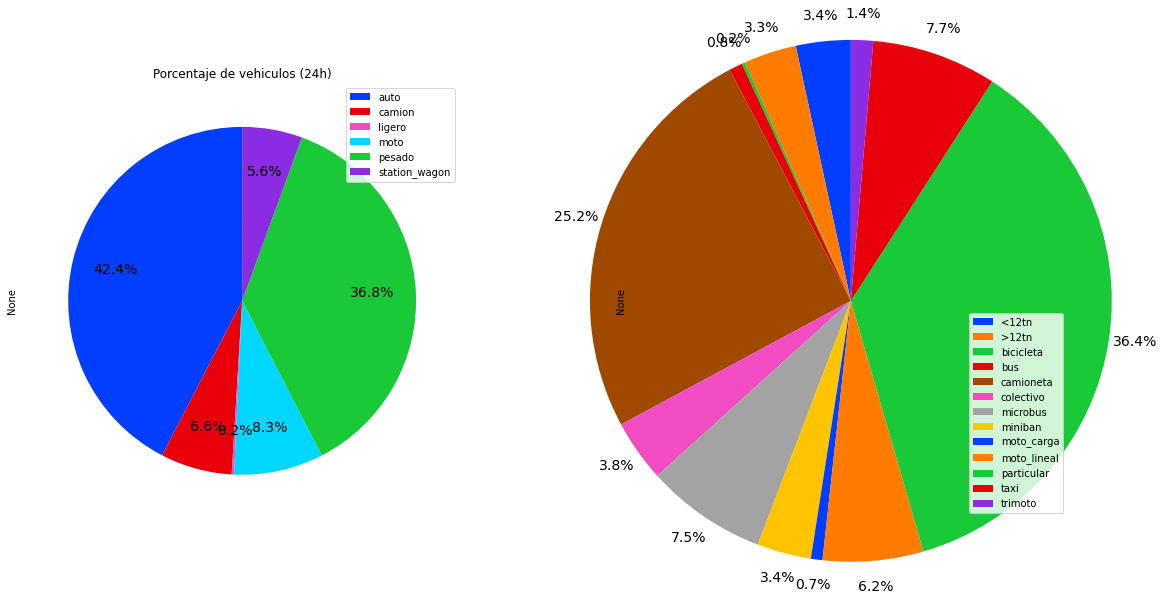

In [156]:
cmap = ListedColormap(sns.color_palette('bright', 15))
fig, ax = plt.subplots(1,2, figsize=(20,8))
fig.patch.set_facecolor('white')
ax[0].set_title("Porcentaje de vehiculos (24h)")
data.groupby(level=0, axis=1).sum().sum() \
    .plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, colormap=cmap, legend=True, labels=None, pctdistance=.75, labeldistance=1.2, fontsize=14, radius=1.0)
# ax[0].legend('lower left')
aaa = data.groupby(level=1, axis=1).sum().sum()
aaa \
    .plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, colormap=cmap, legend=True, labels=None, pctdistance=1.1, labeldistance=1.2, fontsize=14, radius=1.5)
# ax[1].legend()
plt.show()

In [158]:
plt.close("all")